# <a id='toc1_'></a>[Images classification notebook](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [Images classification notebook](#toc1_)    
  - [Imports des libraries](#toc1_1_)    
  - [Lecture du dataframe](#toc1_2_)    
- [Data Preprocessing](#toc2_)    
  - [Data Augmentation](#toc2_1_)    
    - [Test and Visualise  with one image](#toc2_1_1_)    
    - [With the dataset](#toc2_1_2_)    
- [Transfer Learning with Resnet50](#toc3_)    
  - [Definir le modèle](#toc3_1_)    
  - [Compilation du modèle](#toc3_2_)    
  - [Entrainement](#toc3_3_)    
    - [Visualisation](#toc3_3_1_)    
      - [Courbes d'apprentissages](#toc3_3_1_1_)    
      - [Matrice de confusion](#toc3_3_1_2_)    
- [Conclusion](#toc4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Imports des libraries](#toc0_)

In [2]:
import os

import pandas as pd
from tqdm import tqdm
import numpy as np

tqdm.pandas()

import albumentations as A
import cv2

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Precision, Recall, AUC, F1Score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

os.environ["TF_KERAS"] = "1"
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

c:\Users\vuill\OneDrive\Documents\GitHub\OpenClassrooms\Projet 6 - Classifiez automatiquement des biens de consommation\.venv_p6\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Num GPUs Available:  0


## <a id='toc1_2_'></a>[Lecture du dataframe](#toc0_)

In [84]:
DATA_PATH = "../data"
IMAGES_FOLDER_PATH = os.path.join(DATA_PATH, "Flipkart/Images")

df = pd.read_csv(os.path.join(DATA_PATH, "image_classification.csv"))

# Suppression de la colonne inutile 'Unnamed: 0'
df.drop("Unnamed: 0", axis=1, inplace=True)

# Renommage de la colonne 'image' en 'image_path'
df.rename(columns={'image': 'image_path'}, inplace=True)

df.head()

,image_path,label_name,label
0,../data\FlipKart\Images\55b85ea15a1536d46b7190...,Home Furnishing,4
1,../data\FlipKart\Images\7b72c92c2f6c40268628ec...,Baby Care,0
2,../data\FlipKart\Images\64d5d4a258243731dc7bbb...,Baby Care,0
3,../data\FlipKart\Images\d4684dcdc759dd9cdf4150...,Home Furnishing,4
4,../data\FlipKart\Images\6325b6870c54cd47be6ebf...,Home Furnishing,4


In [ ]:
# Afficher le nombre de labels
label_number = len(df["label"].unique())
print(label_number)

7


# <a id='toc2_'></a>[Data Preprocessing](#toc0_)

In [ ]:
# Decoupage des données
X, y = df['image_path'], df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y ,test_size=0.3, random_state=42)


X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, stratify=y_test, test_size=0.15, random_state=42)

## <a id='toc2_1_'></a>[Data Augmentation](#toc0_)

Sources : [Albumentation for the image classification](https://www.albumentations.ai/docs/3-basic-usage/image-classification/)

In [87]:
TARGET_SIZE = 224
BATCH_SIZE = 16

In [88]:
train_transform = A.Compose([
    A.SmallestMaxSize(max_size=TARGET_SIZE, p=1.0),
    A.RandomCrop(height=TARGET_SIZE, width=TARGET_SIZE, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.ShiftScaleRotate(p=0.3),
    A.HueSaturationValue(p=0.2),
    A.CoarseDropout(p=0.2),  # masquer des zones
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

c:\Users\223115316\Documents\GitHub\OC\Projet6\.venv_cv\lib\site-packages\albumentations\core\validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [ ]:
test_val_transform = A.Compose([
    A.SmallestMaxSize(max_size=TARGET_SIZE, p=1.0),
    # Take a crop from the center
    A.CenterCrop(height=TARGET_SIZE, width=TARGET_SIZE, p=1.0),
    # Normalize using ImageNet presets
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

### <a id='toc2_1_1_'></a>[Test and Visualise  with one image](#toc0_)

In [90]:
def load_image(image_path):
    # Charger l'image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def apply_transformations(image, transform, num_epochs=5):
    augmented_images = []
    for _ in range(num_epochs):
        augmented = transform(image=image)
        augmented_image = augmented['image']
        augmented_images.append(augmented_image)
    return augmented_images

def visualize_augmentations(original_image, augmented_images):
    num_images = len(augmented_images)
    figure, ax = plt.subplots(1, num_images + 1, figsize=(15, 5))

    # Display original
    ax[0].imshow(original_image)
    ax[0].set_title("Original")
    ax[0].axis("off")

    # Display augmented versions
    for i in range(num_images):
        ax[i+1].imshow(augmented_images[i])
        ax[i+1].set_title(f"Augmented {i+1}")
        ax[i+1].axis("off")

    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4308496].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..1.8905447].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


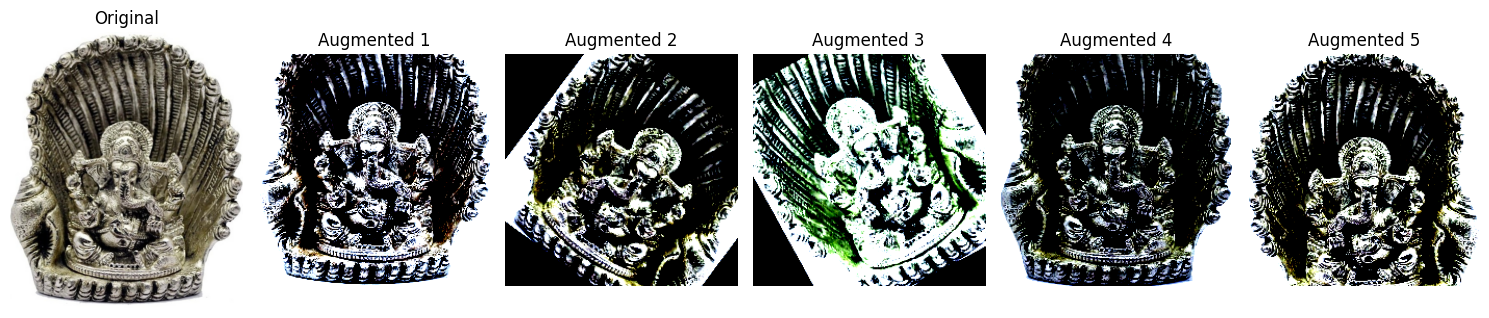

In [ ]:
# Charger l'image originale
original_image = load_image(X_train.iloc[0])

# Appliquer les transformations plusieurs fois à la même image
augmented_images = apply_transformations(original_image, train_transform, num_epochs=5)

# Visualiser les images augmentées
visualize_augmentations(original_image, augmented_images)


### <a id='toc2_1_2_'></a>[With the dataset](#toc0_)

In [92]:
def load_and_transform_image(image_path, transform):
    # Charger l'image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Appliquer la transformation
    augmented = transform(image=image)
    augmented_image = augmented['image']

    # Convertir en tenseur TensorFlow
    augmented_image = tf.convert_to_tensor(augmented_image, dtype=tf.float32)

    return augmented_image

def create_dataset(image_paths, transform):
    images = [load_and_transform_image(image_path, transform) for image_path in image_paths]
    return tf.data.Dataset.from_tensor_slices(images)

In [ ]:
# Créer les datasets
train_dataset = create_dataset(X_train, train_transform)
test_dataset = create_dataset(X_test, test_val_transform)
val_dataset = create_dataset(X_val, test_val_transform)

# Convertir les labels en tenseurs TensorFlow
# Convertir les étiquettes en one-hot encoding
label_number = len(set(y_train))  # Nombre de classes
train_labels = to_categorical(y_train, num_classes=label_number)
test_labels = to_categorical(y_test, num_classes=label_number)
val_labels = to_categorical(y_val, num_classes=label_number)

# Créer des datasets avec les images et les étiquettes
train_dataset = tf.data.Dataset.zip((train_dataset, tf.data.Dataset.from_tensor_slices(train_labels)))
test_dataset = tf.data.Dataset.zip((test_dataset, tf.data.Dataset.from_tensor_slices(test_labels)))
val_dataset = tf.data.Dataset.zip((val_dataset, tf.data.Dataset.from_tensor_slices(val_labels)))

# Préparer les datasets pour l'entraînement
BATCH_SIZE = 16

train_dataset = train_dataset.shuffle(buffer_size=len(X_train)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# <a id='toc3_'></a>[Transfer Learning with Resnet50](#toc0_)
ResNet est considéré comme l'une des meilleures architectures CNN en raison de plusieurs avantages clés :

- Capacité à former des réseaux plus profonds : Grâce à ses blocs résiduels, ResNet peut maintenir des gradients stables, permettant ainsi des architectures beaucoup plus profondes que ses prédécesseurs.

- Meilleure performance : ResNet capture des caractéristiques hiérarchiques complexes et offre une meilleure performance dans diverses tâches de vision par ordinateur.

- Réduction du surapprentissage : Les blocs résiduels réduisent le risque de surapprentissage, améliorant la généralisation du modèle.

- Adaptabilité et transfertabilité : ResNet est largement utilisé pour le transfer learning en raison de sa capacité à apprendre des représentations générales

## <a id='toc3_1_'></a>[Definir le modèle](#toc0_)

In [ ]:
model = ResNet50(include_top=False, weights="imagenet")
print(len([print(i, layer.name, layer.trainable) for i, layer in enumerate(model.layers)]))
    


0 input_3 True
1 conv1_pad True
2 conv1_conv True
3 conv1_bn True
4 conv1_relu True
5 pool1_pad True
6 pool1_pool True
7 conv2_block1_1_conv True
8 conv2_block1_1_bn True
9 conv2_block1_1_relu True
10 conv2_block1_2_conv True
11 conv2_block1_2_bn True
12 conv2_block1_2_relu True
13 conv2_block1_0_conv True
14 conv2_block1_3_conv True
15 conv2_block1_0_bn True
16 conv2_block1_3_bn True
17 conv2_block1_add True
18 conv2_block1_out True
19 conv2_block2_1_conv True
20 conv2_block2_1_bn True
21 conv2_block2_1_relu True
22 conv2_block2_2_conv True
23 conv2_block2_2_bn True
24 conv2_block2_2_relu True
25 conv2_block2_3_conv True
26 conv2_block2_3_bn True
27 conv2_block2_add True
28 conv2_block2_out True
29 conv2_block3_1_conv True
30 conv2_block3_1_bn True
31 conv2_block3_1_relu True
32 conv2_block3_2_conv True
33 conv2_block3_2_bn True
34 conv2_block3_2_relu True
35 conv2_block3_3_conv True
36 conv2_block3_3_bn True
37 conv2_block3_add True
38 conv2_block3_out True
39 conv3_block1_1_conv Tru

In [3]:
model = ResNet50(include_top=False, weights="imagenet")

for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

# Desactiver l'entrainement des couches
for layer in model.layers[:-50]:
    layer.trainable = False

# Ajout de couches
model = Sequential(
    [
        model,
        GlobalAveragePooling2D(),
        Dropout(0.5),
        Dense(2048, activation="relu"),
        Dropout(0.2),
        Dense(1024, activation="relu"),
        Dropout(0.5),
        Dense(1024, activation="relu"),
        Dense(7, activation="softmax", kernel_regularizer=l2(0.001)),
        
    ]
)


0 input_1 True
1 conv1_pad True
2 conv1_conv True
3 conv1_bn True
4 conv1_relu True
5 pool1_pad True
6 pool1_pool True
7 conv2_block1_1_conv True
8 conv2_block1_1_bn True
9 conv2_block1_1_relu True
10 conv2_block1_2_conv True
11 conv2_block1_2_bn True
12 conv2_block1_2_relu True
13 conv2_block1_0_conv True
14 conv2_block1_3_conv True
15 conv2_block1_0_bn True
16 conv2_block1_3_bn True
17 conv2_block1_add True
18 conv2_block1_out True
19 conv2_block2_1_conv True
20 conv2_block2_1_bn True
21 conv2_block2_1_relu True
22 conv2_block2_2_conv True
23 conv2_block2_2_bn True
24 conv2_block2_2_relu True
25 conv2_block2_3_conv True
26 conv2_block2_3_bn True
27 conv2_block2_add True
28 conv2_block2_out True
29 conv2_block3_1_conv True
30 conv2_block3_1_bn True
31 conv2_block3_1_relu True
32 conv2_block3_2_conv True
33 conv2_block3_2_bn True
34 conv2_block3_2_relu True
35 conv2_block3_3_conv True
36 conv2_block3_3_bn True
37 conv2_block3_add True
38 conv2_block3_out True
39 conv3_block1_1_conv Tru

## <a id='toc3_2_'></a>[Compilation du modèle](#toc0_)

Quel  optimizer choisir: [valuating the Impact of Optimizer Hyperparameters on ResNet in Hanacaraka Character Recognition](https://www.degruyterbrill.com/document/doi/10.1515/pdtc-2024-0061/html?srsltid=AfmBOopII1U9iMrGXWhHeUDIsK8t_XNITDWozdhXQFvDotclQghCTIkf) 

Quel loss function choisir: [How to Choose Loss Functions When Training Deep Learning Neural Networks](https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/)

In [150]:
from tensorflow.keras.optimizers import AdamW
optimizer = AdamW(learning_rate=1e-4, weight_decay=1e-5)


In [ ]:
model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=[
        "accuracy",
        Precision(name="precision"),
        Recall(name="recall"),
        AUC(name="auc"),
        F1Score(name="f1_score", average="macro")
    ]
)

## <a id='toc3_3_'></a>[Entrainement](#toc0_)

In [152]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import datetime
now = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

callbacks_list = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.2),
    ModelCheckpoint(
    filepath=f"model-resnet50-{now}.h5",        # nom du fichier de sortie
    save_best_only=True,             # ne sauvegarde que si val_loss s'améliore
    monitor="val_loss",              # critère de monitoring
    mode="min",                      # on veut minimiser val_loss
    save_weights_only=False,         # on sauvegarde tout le modèle, pas juste les poids
    verbose=1                        # affiche un message à chaque save
)
]


# Entraîner le modèle
history = model.fit(train_dataset, epochs=15, validation_data=val_dataset, callbacks=callbacks_list)


print('-' * 100)

# Évaluation du modèle
results = model.evaluate(test_dataset)

# Décompresser les résultats
test_loss, test_accuracy, test_precision, test_recall, test_auc, test_f1_score = results

# # Afficher les résultats
# print(f"Test Loss: {test_loss:.4f}")
# print(f"Test Accuracy: {test_accuracy:.4f}")
# print(f"Test Precision: {test_precision:.4f}")
# print(f"Test Recall: {test_recall:.4f}")
# print(f"Test AUC: {test_auc:.4f}")
# print(f"Test F1 Score: {test_f1_score:.4f}")


Epoch 1/15


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - accuracy: 0.1451 - auc: 0.5176 - f1_score: 0.1351 - loss: 2.4046 - precision: 0.1677 - recall: 0.0380
Epoch 1: val_loss improved from inf to 1.67903, saving model to model-resnet50-20250408-185957.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 35s 606ms/step - accuracy: 0.1461 - auc: 0.5189 - f1_score: 0.1363 - loss: 2.3995 - precision: 0.1699 - recall: 0.0384 - val_accuracy: 0.3333 - val_auc: 0.7419 - val_f1_score: 0.2935 - val_loss: 1.6790 - val_precision: 0.8000 - val_recall: 0.0833 - learning_rate: 1.0000e-04
Epoch 2/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - accuracy: 0.3255 - auc: 0.7066 - f1_score: 0.3166 - loss: 1.7850 - precision: 0.5831 - recall: 0.1397
Epoch 2: val_loss improved from 1.67903 to 1.41201, saving model to model-resnet50-20250408-185957.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 29s 633ms/step - accuracy: 0.3264 - auc: 0.7071 - f1_score: 0.3176 - loss: 1.7835 - precision: 0.5843 - recall: 0.1401 - val_accuracy: 0.5208 - val_auc: 0.8553 - val_f1_score: 0.4985 - val_loss: 1.4120 - val_precision: 0.8182 - val_recall: 0.1875 - learning_rate: 1.0000e-04
Epoch 3/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 697ms/step - accuracy: 0.4648 - auc: 0.8031 - f1_score: 0.4515 - loss: 1.4815 - precision: 0.7208 - recall: 0.2429
Epoch 3: val_loss improved from 1.41201 to 1.22708, saving model to model-resnet50-20250408-185957.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 34s 735ms/step - accuracy: 0.4654 - auc: 0.8036 - f1_score: 0.4522 - loss: 1.4803 - precision: 0.7205 - recall: 0.2433 - val_accuracy: 0.5833 - val_auc: 0.8805 - val_f1_score: 0.5600 - val_loss: 1.2271 - val_precision: 0.6923 - val_recall: 0.3750 - learning_rate: 1.0000e-04
Epoch 4/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 976ms/step - accuracy: 0.6355 - auc: 0.8954 - f1_score: 0.6294 - loss: 1.1111 - precision: 0.8283 - recall: 0.4403
Epoch 4: val_loss did not improve from 1.22708
46/46 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.6349 - auc: 0.8953 - f1_score: 0.6288 - loss: 1.1118 - precision: 0.8274 - recall: 0.4398 - val_accuracy: 0.5625 - val_auc: 0.8685 - val_f1_score: 0.5521 - val_loss: 1.2538 - val_precision: 0.6296 - val_recall: 0.3542 - learning_rate: 1.0000e-04
Epoch 5/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 663s/step - accuracy: 0.6855 - auc: 0.9270 - f1_score: 0.6841 - loss: 0.9406 - precision: 0.8319 - recall: 0.5203   
Epoch 5: val_loss did not improve from

46/46 ━━━━━━━━━━━━━━━━━━━━ 37s 797ms/step - accuracy: 0.7536 - auc: 0.9589 - f1_score: 0.7474 - loss: 0.7260 - precision: 0.9020 - recall: 0.6435 - val_accuracy: 0.6458 - val_auc: 0.8873 - val_f1_score: 0.6222 - val_loss: 1.1964 - val_precision: 0.6857 - val_recall: 0.5000 - learning_rate: 2.0000e-05
Epoch 7/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 759ms/step - accuracy: 0.8116 - auc: 0.9741 - f1_score: 0.8061 - loss: 0.5999 - precision: 0.9046 - recall: 0.7081
Epoch 7: val_loss improved from 1.19638 to 1.18702, saving model to model-resnet50-20250408-185957.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 37s 806ms/step - accuracy: 0.8112 - auc: 0.9740 - f1_score: 0.8058 - loss: 0.6008 - precision: 0.9043 - recall: 0.7076 - val_accuracy: 0.6458 - val_auc: 0.8895 - val_f1_score: 0.6276 - val_loss: 1.1870 - val_precision: 0.7027 - val_recall: 0.5417 - learning_rate: 2.0000e-05
Epoch 8/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 794ms/step - accuracy: 0.8339 - auc: 0.9771 - f1_score: 0.8291 - loss: 0.5515 - precision: 0.9216 - recall: 0.7380
Epoch 8: val_loss improved from 1.18702 to 1.16575, saving model to model-resnet50-20250408-185957.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 39s 844ms/step - accuracy: 0.8340 - auc: 0.9771 - f1_score: 0.8293 - loss: 0.5511 - precision: 0.9216 - recall: 0.7380 - val_accuracy: 0.6667 - val_auc: 0.8938 - val_f1_score: 0.6580 - val_loss: 1.1657 - val_precision: 0.7368 - val_recall: 0.5833 - learning_rate: 2.0000e-05
Epoch 9/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 837ms/step - accuracy: 0.8555 - auc: 0.9811 - f1_score: 0.8559 - loss: 0.5114 - precision: 0.9240 - recall: 0.7485
Epoch 9: val_loss did not improve from 1.16575
46/46 ━━━━━━━━━━━━━━━━━━━━ 40s 871ms/step - accuracy: 0.8555 - auc: 0.9811 - f1_score: 0.8559 - loss: 0.5115 - precision: 0.9239 - recall: 0.7487 - val_accuracy: 0.6458 - val_auc: 0.8880 - val_f1_score: 0.6301 - val_loss: 1.1759 - val_precision: 0.7368 - val_recall: 0.5833 - learning_rate: 2.0000e-05
Epoch 10/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 832ms/step - accuracy: 0.8577 - auc: 0.9849 - f1_score: 0.8539 - loss: 0.4733 - precision: 0.9459 - recall: 0.7723
Epoch 10: val_loss improved from 1.1

46/46 ━━━━━━━━━━━━━━━━━━━━ 40s 875ms/step - accuracy: 0.8580 - auc: 0.9849 - f1_score: 0.8544 - loss: 0.4726 - precision: 0.9460 - recall: 0.7728 - val_accuracy: 0.6667 - val_auc: 0.8989 - val_f1_score: 0.6521 - val_loss: 1.1386 - val_precision: 0.7250 - val_recall: 0.6042 - learning_rate: 2.0000e-05
Epoch 11/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 714ms/step - accuracy: 0.8881 - auc: 0.9913 - f1_score: 0.8875 - loss: 0.3858 - precision: 0.9547 - recall: 0.8100
Epoch 11: val_loss did not improve from 1.13857
46/46 ━━━━━━━━━━━━━━━━━━━━ 34s 743ms/step - accuracy: 0.8880 - auc: 0.9913 - f1_score: 0.8873 - loss: 0.3858 - precision: 0.9544 - recall: 0.8102 - val_accuracy: 0.6875 - val_auc: 0.8921 - val_f1_score: 0.6739 - val_loss: 1.1566 - val_precision: 0.7317 - val_recall: 0.6250 - learning_rate: 2.0000e-05
Epoch 12/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 663ms/step - accuracy: 0.9055 - auc: 0.9910 - f1_score: 0.9051 - loss: 0.3577 - precision: 0.9617 - recall: 0.8504
Epoch 12: val_loss did not improve

In [ ]:
# import datetime
# now = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# model.save(f'model-resnet50-{now}.h5')

### <a id='toc3_3_1_'></a>[Visualisation](#toc0_)

#### <a id='toc3_3_1_1_'></a>[Courbes d'apprentissages](#toc0_)

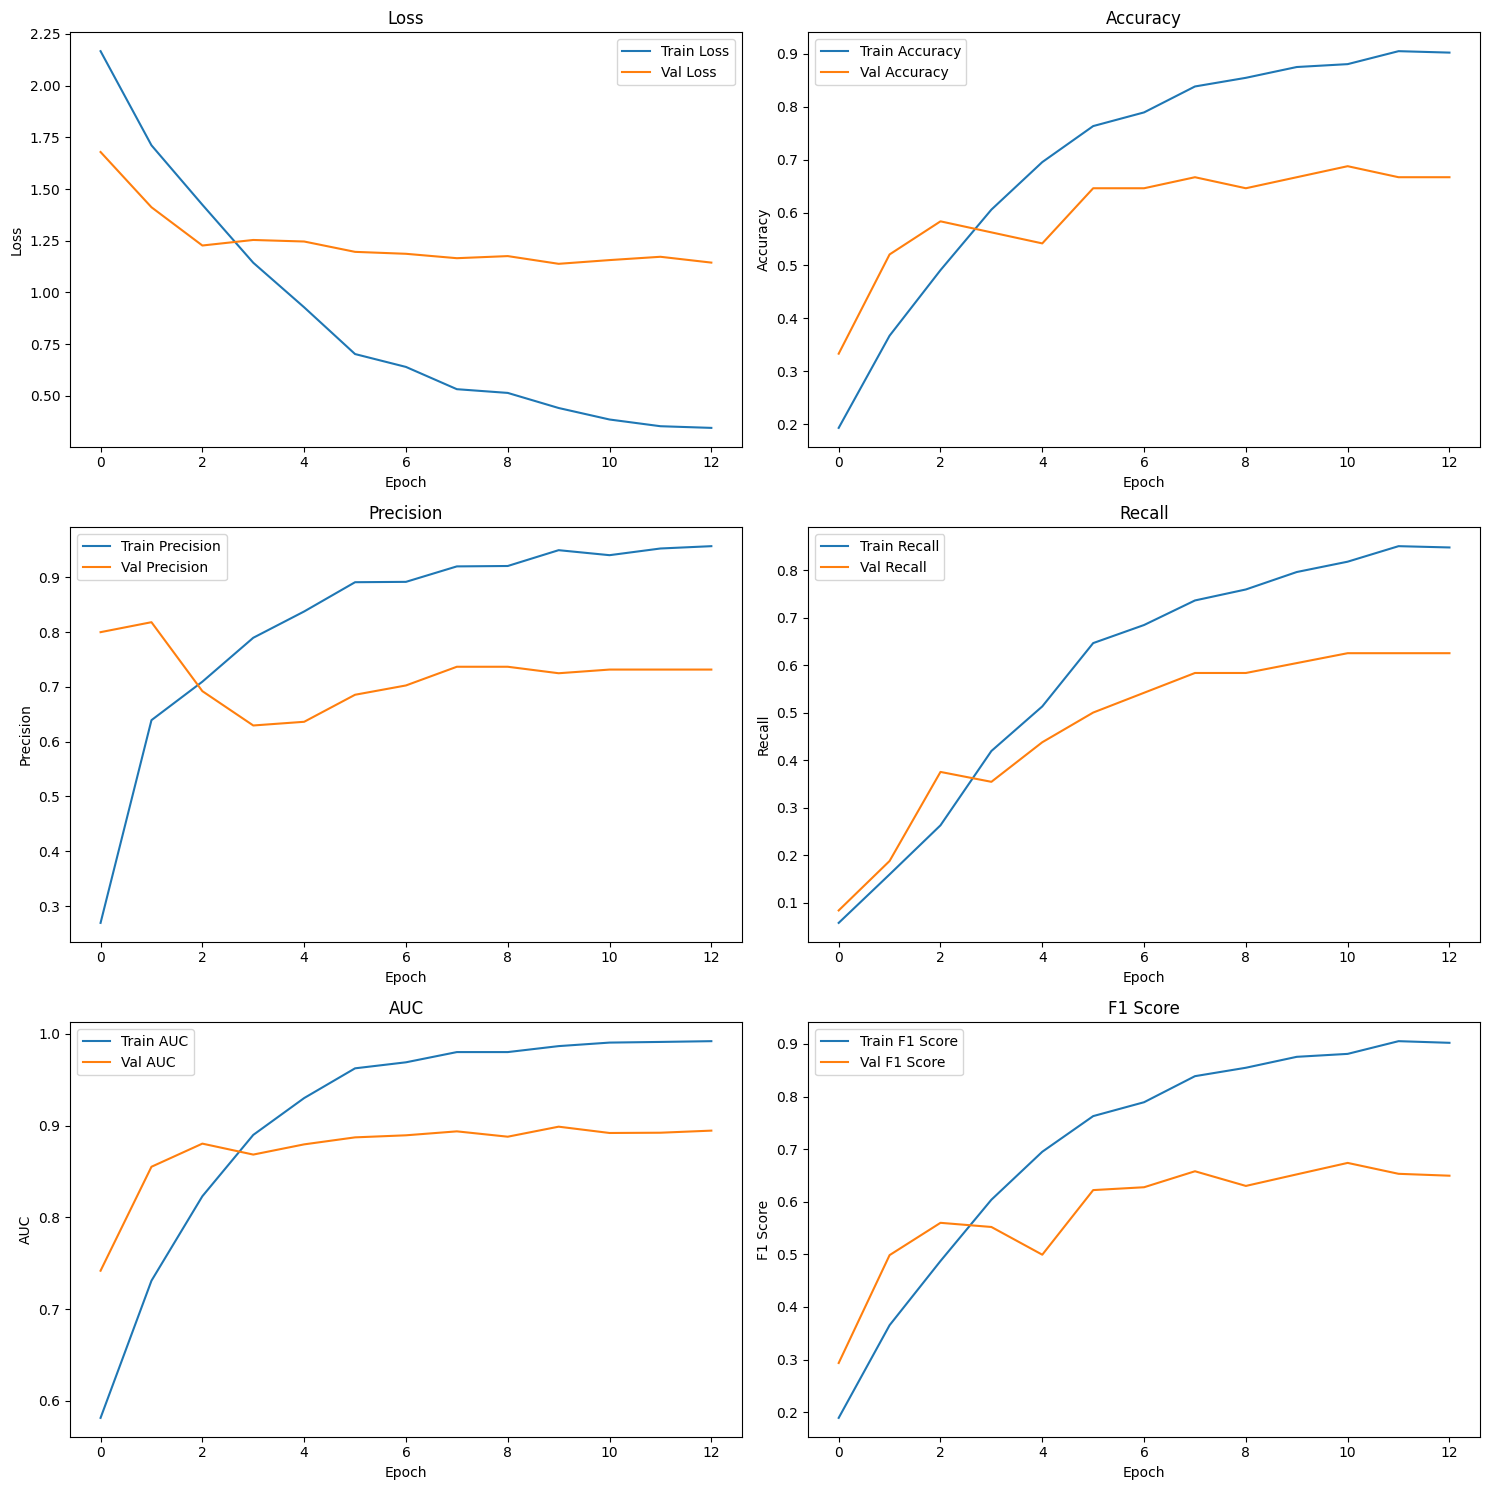

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    # Créer une figure avec plusieurs sous-graphiques
    fig, axes = plt.subplots(3, 2, figsize=(15, 15))  # 3 lignes, 2 colonnes
    axes = axes.flatten()  # Aplatir les axes pour un accès facile

    # Liste des métriques à tracer
    metrics = [
        ('loss', 'Loss'),
        ('accuracy', 'Accuracy'),
        ('precision', 'Precision'),
        ('recall', 'Recall'),
        ('auc', 'AUC'),
        ('f1_score', 'F1 Score')
    ]

    # Tracer chaque métrique
    for i, (metric, title) in enumerate(metrics):
        ax = axes[i]
        train_metric = history.history[metric]
        val_metric = history.history[f'val_{metric}']
        
        # Tracer les courbes d'entraînement et de validation
        ax.plot(train_metric, label=f'Train {title}')
        ax.plot(val_metric, label=f'Val {title}')
        ax.set_title(title)
        ax.set_xlabel('Epoch')
        ax.set_ylabel(title)
        ax.legend()

    # Ajuster la disposition pour éviter les chevauchements
    plt.tight_layout()
    plt.show()

# Appel de la fonction avec l'historique d'entraînement
plot_metrics(history)

#### <a id='toc3_3_1_2_'></a>[Matrice de confusion](#toc0_)

17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 448ms/step


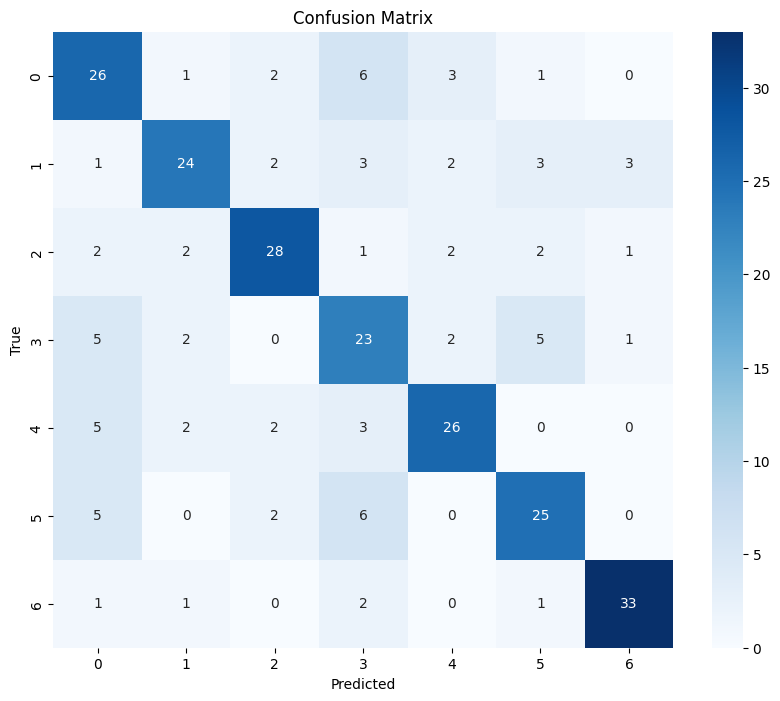

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Prédictions sur les données de test
y_pred = model.predict(test_dataset)
y_pred_classes = tf.argmax(y_pred, axis=1)
y_true = tf.concat([y for x, y in test_dataset], axis=0)
y_true_classes = tf.argmax(y_true, axis=1)

# Matrice de confusion
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Visualiser la matrice de confusion
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(label_number), yticklabels=range(label_number))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# <a id='toc4_'></a>[Conclusion](#toc0_)

Bien que le modèle montre une bonne convergence sur les données d'entraînement avec des métriques satisfaisantes en validation (accuracy ~0.7, F1-score ~0.7–0.8, AUC ~0.8–0.9), il présente des signes d'overfitting après 4 à 6 époques, ce qui limite sa capacité à généraliser. Cela peut s'expliquer par le faible volume de données disponibles (1000 exemples seulement), même après l'application de la data augmentation, qui reste insuffisante pour capturer toute la diversité du problème. Avec une base de données limitée, le modèle risque d'apprendre des patterns spécifiques à l'entraînement plutôt que des caractéristiques généralisables, soulignant ainsi la nécessité d'enrichir davantage le jeu de données, La classification est donc possible mais encore imprecise en l'etat il nous faudrai plus de données pour avoir un meilleur modèle